# snap2vec

using stanford social network datasets + word2vec

In [6]:
# you'll probably get a lot of warnings here -- sorry 
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import json
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import hdbscan
% matplotlib inline
output_notebook()

/Users/gmerz/person2vec/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


Loading BokehJS ...

## `1. Preprocessing 

We want to write both sparsified and regular forms of our graph to adjaceny list. We want to test word2vec on various sparsified graphs and see if we can predict links that occur in the full on adjacency list

*Write Full graph*

In [7]:
! python scripts/preprocess_snaps.py twitter_combined.txt 1 directed

Constructing adjacency list
Writing to file


*Write 90% of edges*

In [8]:
! python scripts/preprocess_snaps.py twitter_combined.txt .9 directed

Constructing adjacency list
Writing to file


*Write 80% of edges*

In [9]:
! python scripts/preprocess_snaps.py twitter_combined.txt .8 directed

Constructing adjacency list
Writing to file


*Write 70% of edges*

In [10]:
! python scripts/preprocess_snaps.py twitter_combined.txt .7 directed

Constructing adjacency list
Writing to file


We want to be able to compare the sparisified graphs with the full graph, so we make a quick 
function "adjListFromFile" that loads the adjacency lists from a file in to the front-end so we can directly 
examine it

In [11]:
def adjListFromFile(fpath):
    ''' 
        function that constructs a dictionary 
        of nodes -> list of nodes their connected to
        (an adjacency list representation of the graph)
        from a file
    '''
    adjList = {}
    with open(fpath, 'r') as f: 
        for i, line in enumerate(f): 
            # first line of a file is a marker 
            # of whether or not theg graph is 
            # weighted -- we know our 
            # graph isn't weighted so 
            # we don't care
            if i != 0: 
                totalList = line.strip().split(' ')
                adjList[totalList[0]] = [x.strip() for x in totalList[1:]]
    return adjList 

In [12]:
# get some graphs
fullGraph = adjListFromFile('graphs/twitter_combine1_lst.txt')
partialGraph = adjListFromFile('graphs/twitter_combine0.9_lst.txt')
partialGraphS = adjListFromFile('graphs/twitter_combine0.7_lst.txt')

Now that we have our graphs, we want to do a couple quick sanity 
checks to make sure that everything is working correctly. 

We first check that the number of nodes in the graph are degreasing 
(namely, that the fullGraph >= partialGraph >= partialGraphS)

In [13]:
# sanity check 
print(len(fullGraph), len(partialGraph), len(partialGraphS))

70097 69486 67896


Then, we want to check that every note in each of the partial graphs is in the full graph -- i.e., we haven't
created any new nodes out of nowhere 

In [14]:
def testNodes(partialGraph, fullGraph):
    '''
        another quick sanity check: function that 
        ensures every node in the partial graph
        is also in the full graph 
        
        (this wasn't the case before -- there was a bug
        where spaces weren't written but i fixed hehe)
    '''
    num_errors = 0 
    for node_id in partialGraph.keys(): 
        if node_id not in fullGraph.keys(): 
            num_errors += 1 
    return num_errors

assert not(testNodes(partialGraph, fullGraph))
assert not(testNodes(partialGraphS, fullGraph))

Finally, we can perform our random walks and write them to a file! 

In [41]:
! python scripts/documentize.py graphs/twitter_combine0.7_lst.txt text_docs/70/twitter_.01_1.txt  .01 100000

PROCESSING GRAPH
WRITING TO FILE


In [42]:
! python scripts/documentize.py graphs/twitter_combine0.7_lst.txt text_docs/70/twitter_.005_1.txt .005 100000

PROCESSING GRAPH
WRITING TO FILE


In [43]:
! python scripts/documentize.py graphs/twitter_combine0.7_lst.txt text_docs/70/twitter_.001_1.txt .001 100000

PROCESSING GRAPH
WRITING TO FILE


In [44]:
! python scripts/documentize.py graphs/twitter_combine0.7_lst.txt  text_docs/70/twitter_.01_5.txt .01 500000

PROCESSING GRAPH
WRITING TO FILE


In [45]:
! python scripts/documentize.py graphs/twitter_combine0.7_lst.txt  text_docs/70/twitter_.005_5.txt .005 500000

PROCESSING GRAPH
WRITING TO FILE


In [46]:
! python scripts/documentize.py graphs/twitter_combine0.7_lst.txt  text_docs/70/twitter_.001_5.txt .001 500000

PROCESSING GRAPH
WRITING TO FILE


In [47]:
! python scripts/documentize.py graphs/twitter_combine0.7_lst.txt  text_docs/70/twitter_.01_10.txt .01 1000000

PROCESSING GRAPH
WRITING TO FILE


In [48]:
! python scripts/documentize.py graphs/twitter_combine0.7_lst.txt  text_docs/70/twitter_.005_10.txt .005 1000000

PROCESSING GRAPH
WRITING TO FILE


In [49]:
! python scripts/documentize.py graphs/twitter_combine0.7_lst.txt  text_docs/70/twitter_.001_10.txt .001 1000000

PROCESSING GRAPH
WRITING TO FILE


In [50]:
import os

In [58]:
times = []
for filename in os.listdir('text_docs/90'):
    if filename.endswith(".txt"):
        full_name = 'text_docs/90/' + filename
        fname = filename[:-4]
        model = Word2Vec(LineSentence(full_name), size = 100, window = 5, min_count=100, workers=4)
        model.save('models/90/' + fname + '.txt')
    else:
        continue

## 2. word2vec

We generate the word2vec model as follows. The LineSentence class imported from gensim takes in .txt or .bz2 file where "words" (node id's) are written seperated by new line characters and "documents" (random walks across graphs) are written seperated by newline characters. word2vec then trains the model with the given parameters: 

* size: the size of the vectors outputted by word2vec. each node will correspond to a 100 dimmensional vector right now 
* window: the size of the sliding window over the "words" in the sentence" i.e. the nodes in the graph
* min_count: the minimum number of time a node must appear in our document in order to be considered 
* workers: how many workers you parallelize the training with (there's a C compiler over the hood) 



In [17]:
%%time
model = Word2Vec(LineSentence('twitter.7vec.txt'), size=100, window=5, min_count=100, workers=4)

CPU times: user 6.68 s, sys: 162 ms, total: 6.85 s
Wall time: 5.22 s


In [93]:
def testPrediction(fullGraph, partialGraph, model):
    numExisting, numFound, numWrong = 0, 0, 0
    for i, user_id in enumerate(model.vocab.keys()):
        most_similar = [t[0] for t in model.most_similar(user_id)]
        for similar_user in most_similar: 
            if similar_user in partialGraph[user_id]:
                numExisting += 1
            elif similar_user in fullGraph[user_id]: 
                numFound += 1 
            else: 
                numWrong += 1 
    return (numExisting, numFound, numWrong)

In [19]:
testPrediction(fullGraph, partialGraphS, model)

On word 0 out of 1092


(3593, 127, 1740)

In [64]:
adjListFromFile('graphs/twitter_combine1_lst.txt')

{'338266202': ['38435868', '300564635', '72472227'],
 '59993243': ['122216533'],
 '78792100': ['10400902',
  '814304',
  '16723958',
  '16010789',
  '2384071',
  '839321',
  '1585',
  '18917203',
  '13130412',
  '3715',
  '14553055',
  '1285451',
  '18889063',
  '16463326',
  '16433562',
  '14445542',
  '17843236',
  '36823',
  '11504382',
  '11388132',
  '15101375',
  '12384312',
  '15378805',
  '1175221',
  '12095912',
  '46220856',
  '9255722',
  '14503316',
  '21909890',
  '15753937',
  '11346482',
  '14533116',
  '6141832'],
 '19693287': ['326620473',
  '20648508',
  '433095950',
  '80225921',
  '115485051',
  '18738619',
  '657863',
  '26178743',
  '18980276',
  '22421051',
  '42343110'],
 '12958782': ['14239638', '27696744', '6610442'],
 '78308028': ['123029983',
  '284667485',
  '220489538',
  '445522298',
  '236888134',
  '129490768',
  '230002504',
  '233598791',
  '215785630',
  '268039942',
  '272741153',
  '279590641',
  '208549187',
  '14230524',
  '117674417',
  '2284646

In [103]:
import random

In [104]:
def randomBaseline(fullGraph, partialGraph, totalGuesses): 
    numExisting, numFound, numWrong = 0, 0, 0
    total = list(partialGraph.keys())
    while totalGuesses > 0: 
        node1 = random.choice(total)
        node2 = random.choice(total)
        
        while node1 == node2: 
            node2 = random.choice(total)
            
        if node2 in partialGraph[node1]: 
            numExisting += 1
        elif node2 in fullGraph[node1]: 
            numFound += 1
        else: 
            numWrong += 1 
        
        totalGuesses -= 1 

    return (numExisting, numFound, numWrong)
        

In [105]:
def comparisonPlot(comparisonPercentage): 
    partialGraphPath = 'graphs/'
    partialGraphs = {}
    
    # get all the graphs 
    for filename in os.listdir(partialGraphPath): 
        if filename.endswith('.txt'):
            percentage = filename.split('_')[1][-1]
            partialGraphs[int(percentage)] = adjListFromFile(partialGraphPath + filename)
    modelsPath = 'models/' + str(comparisonPercentage)
    
    accuracyDict = {}
    
    # store all of the numExisting, numFound, numWrong for each model 
    comparisonPercentage = int(comparisonPercentage / 10) 
    for filename in os.listdir(modelsPath): 
        if filename.endswith('.txt'):
            model = Word2Vec.load(modelsPath + '/' + filename)
            model_guesses = testPrediction(partialGraphs[1], partialGraphs[comparisonPercentage], model)
            total_guesses = sum(model_guesses)
            accuracyDict[filename] = [model_guesses, randomBaseline(partialGraphs[1], partialGraphs[comparisonPercentage], total_guesses)]
    return accuracyDict   

In [106]:
dict70 = comparisonPlot(70)

In [114]:
dict80 = comparisonPlot(80)

In [115]:
dict90 = (comparisonPlot(90))

In [288]:
print(dict90)

{'twitter_.01_1.txt': [(8220, 91, 4989), (4, 0, 13296)], 'twitter_.005_10.txt': [(93195, 5854, 82131), (64, 3, 181113)], 'twitter_.01_10.txt': [(89924, 5552, 77904), (59, 4, 173317)], 'twitter_.005_5.txt': [(52760, 2700, 38050), (24, 0, 93486)], 'twitter_.01_5.txt': [(50088, 2536, 35546), (25, 2, 88143)], 'twitter_.001_5.txt': [(55867, 2994, 40509), (35, 4, 99331)], 'twitter_.005_1.txt': [(9039, 111, 5440), (4, 1, 14585)], 'twitter_.001_1.txt': [(9750, 150, 5880), (4, 0, 15776)], 'twitter_.001_10.txt': [(95682, 5978, 85890), (71, 8, 187471)]}


In [331]:
def genDF(dictList): 
    df = []
    for i, dct in enumerate(dictList): 
        for k, v in dct.items(): 
            params = k.split('_')[1], int(k.split('_')[2][:-4]) * 100000
            total = sum(v[0])
            word2vec = float(v[0][1]) / total * 100 
            random = float(v[1][1]) / total * 100
            new_df = pd.DataFrame({'word2vec': [word2vec], 'random': [random], 'sparsity': [(i * 10) + 70] , 'parameters': [params]})
            df.append(new_df)        
    return pd.concat(df)

In [332]:
newdf = genDF([dict70, dict80, dict90])
newdf

,parameters,random,sparsity,word2vec
0,"(.01, 100000)",0.009149,70,2.506862
0,"(.005, 1000000)",0.009882,70,10.054969
0,"(.01, 1000000)",0.010985,70,10.116963
0,"(.005, 500000)",0.011130,70,8.888202
0,"(.01, 500000)",0.009213,70,8.752303
0,"(.001, 500000)",0.008291,70,8.986142
0,"(.005, 100000)",0.025274,70,2.796967
0,"(.001, 100000)",0.030628,70,3.009188
0,"(.001, 1000000)",0.008950,70,10.116348
0,"(.01, 100000)",0.000000,80,1.645676


In [136]:
def genDataFrames(comparisonDict): 
    order_mapping = {'.01': 0,'.005': 1, '.001': 2, '1': 0, '5': 1, '10': 2}
    dataFrames = [[None for _ in range(3)] for _ in range(3)]
    for k, v in comparisonDict.items(): 
        randomRestart, numDocs = k.split('_')[1], k.split('_')[2][:-4]
        word2vec, random = v[0], v[1]
        word2vec_correct = word2vec[1] / float(sum(word2vec))
        random_correct = random[1] / float(sum(random))
        df = pd.DataFrame({'method': ['word2vec', 'random'], 'correct': [word2vec_correct, random_correct]})
        dataFrames[order_mapping[numDocs]][order_mapping[randomRestart]] = df
    return dataFrames

In [156]:
def genPlots(comparisonDict): 
    f, axes = plt.subplots(nrows = 3, ncols = 3, sharex = False, sharey = True, squeeze=False, figsize = (20,10))
    dataFrames = genDataFrames(comparisonDict)
    for i, ax in enumerate(axes): 
        for j, subplot in enumerate(ax): 
            df = dataFrames[i][j]
            sns.barplot(x = 'method', y = 'correct', data = df, ax = subplot, alpha = .8)

In [212]:
def genDataFramesTwo(comparisonDicts): 
    order_mapping = {'.01': 0,'.005': 1, '.001': 2, '1': 0, '5': 1, '10': 2}
    sparsity_mapping = {0: '70%', 1: '80%', 2: '90%'}
    dataFrames = [[None for _ in range(3)] for _ in range(3)]
    for i, comparisonDict in enumerate(comparisonDicts): 
        for k, v in comparisonDict.items(): 
            randomRestart, numDocs = k.split('_')[1], k.split('_')[2][:-4]
            word2vec, random = v[0], v[1]
            word2vec_correct = word2vec[1] / float(sum(word2vec)) * 100
            random_correct = random[1] / float(sum(random)) * 100
            df = pd.DataFrame({'correct': [word2vec_correct], 'sparsity': [sparsity_mapping[i]]})
            og = pd.DataFrame()
            if dataFrames[order_mapping[numDocs]][order_mapping[randomRestart]] is not None:
                og = dataFrames[order_mapping[numDocs]][order_mapping[randomRestart]]
            dataFrames[order_mapping[numDocs]][order_mapping[randomRestart]] = og.append(df)
    return dataFrames

In [333]:
def genPlotsTwo(comparisonDicts): 
    f, axes = plt.subplots(nrows = 3, ncols = 3, sharex = False, sharey = True, squeeze=False, figsize = (10,10))
    f.suptitle("Comparison of Link Prediction Performance Across Document Sizes and Restart Probabilities", fontsize = 16)
    dataFrames = genDataFramesTwo(comparisonDicts)
    for i, ax in enumerate(axes): 
        for j, subplot in enumerate(ax): 
            df = dataFrames[i][j]
            sns.barplot(x = 'sparsity', y = 'correct', data = df, ax = subplot, alpha = .6)
            subplot.set(xlabel = '')
            subplot.set(ylabel = ' ')
    axes[0][0].set(ylabel = '100,000 Documents \n Correct % of Links Predicted')
    axes[1][0].set(ylabel = '500,000 Documents \n Correct % of Links Predicted ')
    axes[2][0].set(ylabel = '1,000,000 Documents \n Correct % of Links Predicted')
    axes[0][0].set_xlabel('Random Walk Restart Probability .01 \n Graph Sparsity') 
    axes[0][1].set_xlabel('Random Walk Restart Probability .005 \n Graph Sparsity')    
    axes[0][2].set_xlabel('Random Walk Restart Probability .001 \n Graph Sparsity')    
    for i in range(3): 
        axes[0][i].xaxis.set_label_position('top')
    return 

In [334]:
sns.set_style('darkgrid')

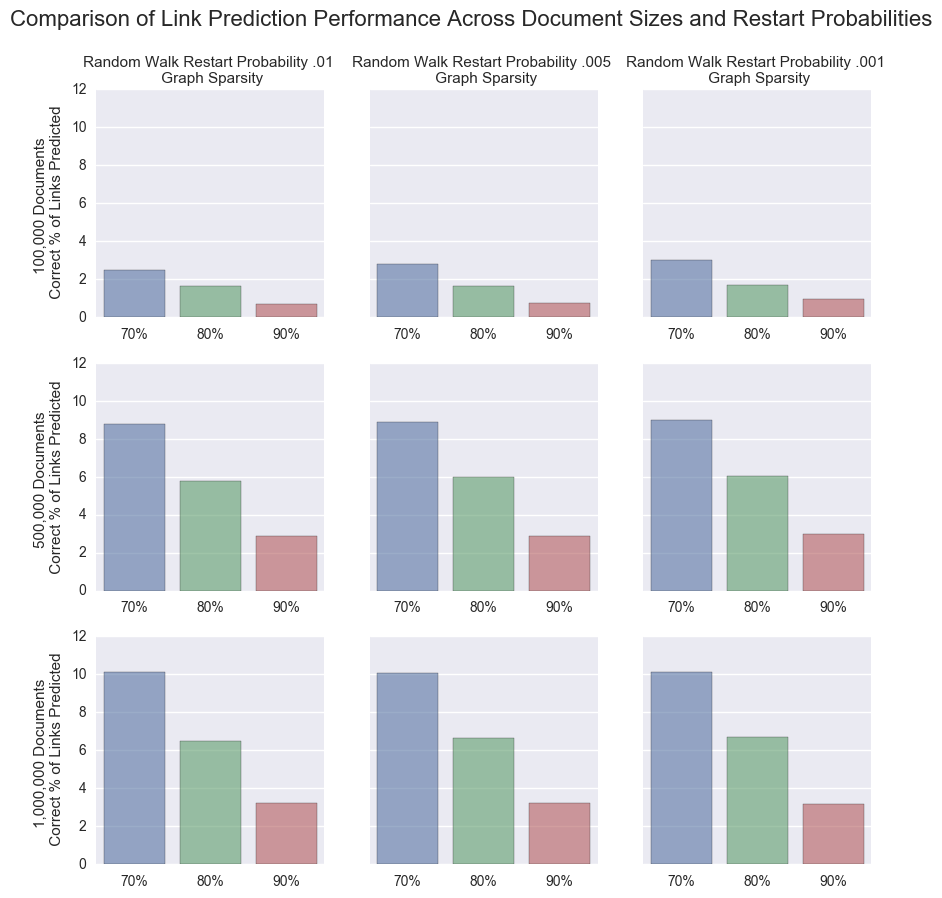

In [335]:
genPlotsTwo([dict70, dict80, dict90])

In [285]:
print('\\textbf{Gabbi}')

\textbf{Gabbi}


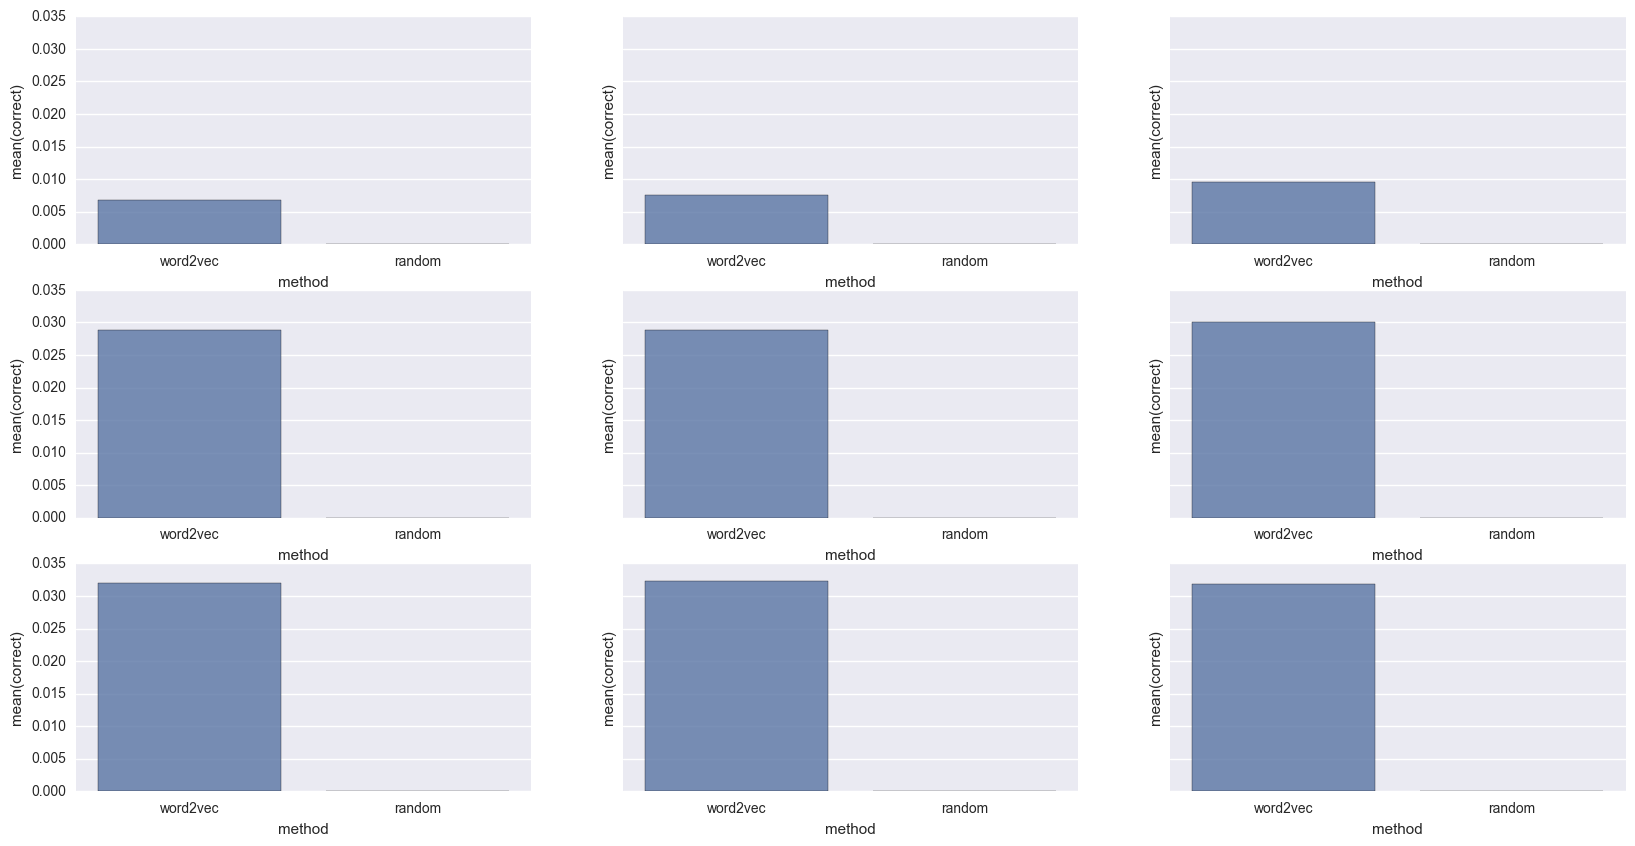

In [160]:
genPlots(dict90)